# Project 3 - Part 2: EDA, Model and Results

In [2]:
# Import related libraries
import requests
import json
import pandas as pd
import numpy as np
import time
import random
import re

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,auc
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Clean Basketball csv 

In [11]:
X_0=pd.read_csv('basketball.csv')
X_0.shape

(987, 107)

In [12]:
# Remove duplicated posts based on their title
X_0.drop_duplicates(subset='title', inplace=True)
X_0.shape

(932, 107)

In [44]:
X_0.columns

Index(['all_awardings', 'allow_live_comments', 'approved_at_utc',
       'approved_by', 'archived', 'author', 'author_cakeday',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext',
       ...
       'title', 'total_awards_received', 'ups', 'url', 'user_reports',
       'view_count', 'visited', 'whitelist_status', 'wls', 'is_baseball'],
      dtype='object', length=108)

In [9]:
# Create a function to display the most frequent 200 words
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

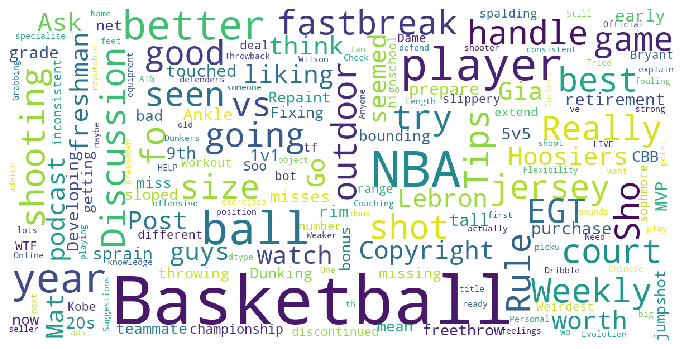

In [18]:
# Most common 200 words in Basketball posts under 'title'
show_wordcloud(X_0['title'])

## Clean Baseball csv

In [13]:
# Saved extracted raw posts as csv file so that I do not need to run the loop everytime.
X_1=pd.read_csv('baseball.csv')
X_1.shape

(1003, 106)

In [14]:
# Drop duplicates for baseball posts
X_1.drop_duplicates(subset='title', inplace=True)
X_1.shape

(924, 106)

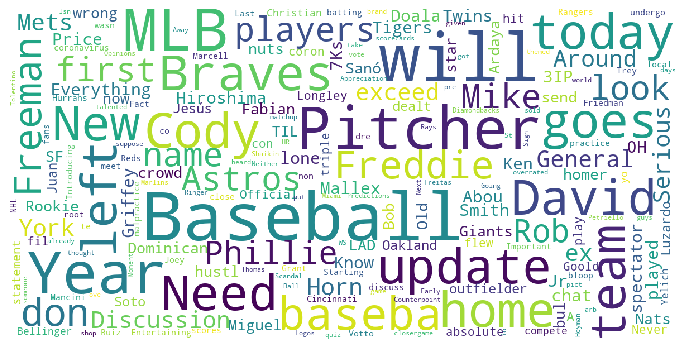

In [28]:
show_wordcloud(X_1['title'])

While the wordcloud from baseball 'title' seems to contain more relevant words than baseball's 'selftext', it is still useful to keep both 'title' and 'selftext' for now.

# Combined Data cleaning and EDA

In [15]:
# Created the target vector. Label '1' for baseball posts.
X_0['is_baseball'] = 0
X_1['is_baseball'] = 1

Text(0.5, 1.0, 'Number of comments on posts')

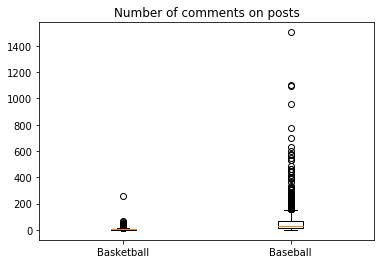

In [55]:
# Number of comments on basketball and baseball posts
basketball_comments=X_0['num_comments']
baseball_comments=X_1['num_comments']

plt.boxplot([basketball_comments,baseball_comments])
plt.xticks([1, 2], ['Basketball', 'Baseball'])
plt.title('Number of comments on posts')

Text(0.5, 1.0, 'Number of ups')

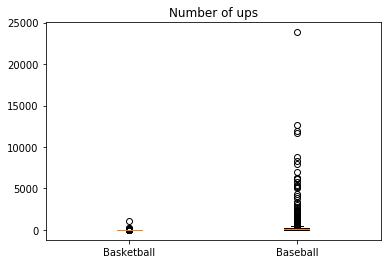

In [57]:
# Popularity of basketball and baseball posts (Number of ups is equivalent to the number of likes)
basketball_ups=X_0['ups']
baseball_ups=X_1['ups']

plt.boxplot([basketball_ups,baseball_ups])
plt.xticks([1, 2], ['Basketball', 'Baseball'])
plt.title('Number of ups')

5.472103004291851
58.98268398268398


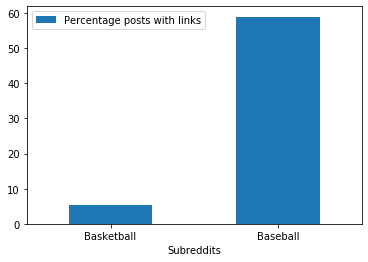

In [62]:
# Percentage of posts with links (videos, articles, pictures)
basketball_post=X_0[(X_0['thumbnail']=='self') |(X_0['thumbnail']=='default')]
basketball_post=100*(1-basketball_post.shape[0]/X_0.shape[0])
print(basketball_post)

baseball_post=X_1[(X_1['thumbnail']=='self') |(X_1['thumbnail']=='default')]
baseball_post=100*(1-baseball_post.shape[0]/X_1.shape[0])
print(baseball_post)

post_link = pd.DataFrame({'Subreddits':['Basketball', 'Baseball'], 'Percentage posts with links':[5.472, 58.982]})
ax = post_link.plot.bar(x='Subreddits',y='Percentage posts with links', rot=0)

In [16]:
# Combined basketball and baseball posts based on three most important data - 'is_baseball', 'title' and 'selftext'
df = X_0.append(X_1, ignore_index=True, sort=True)
df = df[['is_baseball', 'title','selftext']]
df.head()

is_baseball                                              title  \
0            0  Rule: You cannot Ask for or Post Copyright Mat...   
1            0  r/Basketball Weekly Discussion: Basketball Sho...   
2            0                6‚Äô8 freshman. It‚Äôs worth the watch.   
3            0                                   Go Hoosiers!üèÄ‚ö™Ô∏èüî¥   
4            0  Really liking this podcast, you guys think Gia...   

                                            selftext  
0  Admins have banned other subs for this. \n\nNo...  
1  #Welcome to /r/Basketball's weekly Shoe Discus...  
2                                                NaN  
3                                                NaN  
4                                                NaN

In [17]:
df.shape

(1856, 3)

In [18]:
# Out of 1856 posts, 736 of them are missing selftext
df.isnull().sum()

is_baseball      0
title            0
selftext       736
dtype: int64

In [19]:
# Number of missing 'selftext' in basketball posts
X_0['selftext'].isnull().sum()

121

In [20]:
# Number of missing 'selftext' in baseball posts
X_1['selftext'].isnull().sum()

615

Given the large number of missing 'selftext' in baseball posts (more than 50%), it is difficult to impute. However, I am relunctant to discard 'selftext' as I note that 'selftext' can contain additional data and relevant words that may be helpful in training and improving model accuracy. Therefore, the decision is to combine 'selftext' and 'title' to obtain a 'bigger' bag of words since they are both strings.


In [23]:
# Replace missing 'selftext' with spaces
df.fillna('',inplace=True)
df.isnull().sum()

is_baseball    0
title          0
selftext       0
dtype: int64

In [24]:
#Concatenate strings in 'title' with 'selftext' 
df['combine'] = df.title.str.cat(df.selftext)
df.shape

(1856, 4)

In [25]:
# Define X and y 
X=df[['combine']]
y=df['is_baseball']

In [105]:
# Distribution between baseball and basketball posts
y.value_counts(normalize=True)

0    0.502155
1    0.497845
Name: is_baseball, dtype: float64

# Preprocessing of text

In [26]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Get the number of reviews based on the dataframe size.
X_train_data = len(X_train['combine'])
print(f'There are {X_train_data} train posts.')

X_test_data = len(X_test['combine'])
print(f'There are {X_test_data} test posts.')

There are 1392 train posts.
There are 464 test posts.


In [27]:
# Even distribution between baseball and basketball posts
y_train.value_counts(normalize=True)

0    0.502155
1    0.497845
Name: is_baseball, dtype: float64

The baseline prediction for any post to be basketball is 0.5. 

In [28]:
# Created a function to manually preprocess text

lemm = WordNetLemmatizer()
from nltk.corpus import stopwords

def text_processer(raw_text):
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_text).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Remove stop words
    stop_words = set(stopwords.words("english"))
    stop_words.update(['http','com','www','jsp','id','would','hd'])
    filtered_words=[w for w in words if not w in stop_words]

    # 5. Lemmatize words.
    lemmed_words = [lemm.lemmatize(i) for i in filtered_words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(lemmed_words))

In [29]:
# Initialize an empty list to hold the clean reviews.
clean_Xtrain_posts = []
clean_Xtest_posts = []

print("Cleaning and parsing the training set posts...")

j = 0
for row in X_train['combine']:
    # Convert review to words, then append to clean_train_reviews.
    clean_Xtrain_posts.append(text_processer(row))
    
    # If the index is divisible by 200, print a message
    if (j + 1) % 200 == 0:
        print(f'Posts {j + 1} of {X_train_data}.')
    
    j += 1

# Do the same for testing set

print("Cleaning and parsing the testing set posts...")

k = 0
for row in X_test['combine']:
    # Convert review to words, then append to clean_train_reviews.
    clean_Xtest_posts.append(text_processer(row))
    
    # If the index is divisible by 200, print a message
    if (k + 1) % 200 == 0:
        print(f'Review {k + 1} of {X_test_data}.')
        
    k += 1

Cleaning and parsing the training set posts...
Posts 200 of 1392.
Posts 400 of 1392.
Posts 600 of 1392.
Posts 800 of 1392.
Posts 1000 of 1392.
Posts 1200 of 1392.
Cleaning and parsing the testing set posts...
Review 200 of 464.
Review 400 of 464.


In [30]:
# Convert the cleaned train and test data to dataframe
X_train_clean=pd.DataFrame(clean_Xtrain_posts)
X_test_clean=pd.DataFrame(clean_Xtest_posts)

To check if preprocessing improves the accuracy of the model, a simple CountVectorizer is used on data with and with preprocessing in next section.

# EDA using CountVectorizer

In [31]:
# Without preprocessing, CountVectorizer and Logistic Regression are run.

cv_simple = CountVectorizer()
X_train_cv = cv_simple.fit_transform(X_train['combine'])
X_test_cv = cv_simple.transform(X_test['combine'])

print("There are {} features in the model using data without preprocessing.".format(len(cv_simple.get_feature_names())))

lr = LogisticRegressionCV(cv=3)
lr.fit(X_train_cv, y_train)
y_train_pred=lr.predict(X_train_cv)
y_test_pred=lr.predict(X_test_cv)
ROC_AUC_score_train=roc_auc_score(y_train, y_train_pred)
ROC_AUC_score_test=roc_auc_score(y_test, y_test_pred)

print("Train ROC AUC score: {} Test ROC AUC score {}".format(ROC_AUC_score_train, ROC_AUC_score_test))


There are 11598 features in the model using data without preprocessing.
Train ROC AUC score: 0.9992846924177397 Test ROC AUC score 0.9181948237742229


In [40]:
# Run CountVectorizer and LogisticRegression with preprocessing to evaluate if preprocessing could improve accuracy.

cv_simple = CountVectorizer()
X_train_cv = cv_simple.fit_transform(X_train_clean[0])
X_test_cv = cv_simple.transform(X_test_clean[0])

print("There are {} features in the model with pre-processing.".format(len(cv_simple.get_feature_names())))

lr = LogisticRegressionCV(cv=3)
lr.fit(X_train_cv, y_train)
y_train_pred=lr.predict(X_train_cv)
y_test_pred=lr.predict(X_test_cv)
ROC_AUC_score_train=roc_auc_score(y_train, y_train_pred)
ROC_AUC_score_test=roc_auc_score(y_test, y_test_pred)

print("Train score: {} Test score {}".format(ROC_AUC_score_train, ROC_AUC_score_test))


There are 8825 features in the model with pre-processing.
Train score: 0.9992846924177397 Test score 0.9397841071660813


Preprocessing improved the accuracy of the classifier slightly and reduced the number of features given applied techniques like lemmatization and elimination of digits. Preprocessed data were used subsequently.

In [33]:
# Find top 30 most common words
n_words = 30
cv_train = pd.DataFrame(X_train_cv.todense(), columns=cv_simple.get_feature_names())
cv_train.drop(columns='http',inplace=True)
words = list(cv_train.sum().sort_values(ascending=False)[:n_words].index)
cv_train['is_baseball'] = y_train.values
X_train_common = cv_train.groupby('is_baseball').sum()[words]

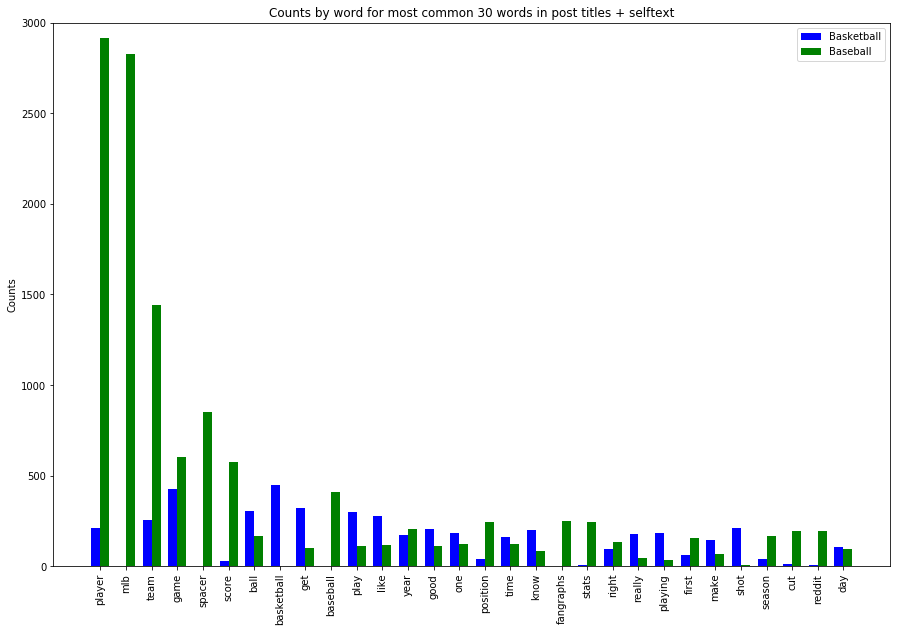

In [41]:
# Compare the counts of the 30 most commons words between basketball and baseball 
words_basketball = words
words_count_basketball = X_train_common.loc[0]
words_baseball = words
words_count_baseball = X_train_common.loc[1]
bar_width = 0.35       # the width of the bars
index = np.arange(n_words)

fig, ax = plt.subplots(figsize=(15, 10))
rects1 = ax.bar(index, words_count_basketball, bar_width, color='b', label='Basketball')
rects2 = ax.bar(index+bar_width,words_count_baseball, bar_width, color='g',label='Baseball')

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts')
ax.set_title('Counts by word for most common 30 words in post titles + selftext')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(words,rotation='vertical')

ax.set_ylim(0,3000)

ax.legend((rects1[0], rects2[0]), ('Basketball', 'Baseball'))

plt.show()


Based on the top 30 most common words, it seemed fairly easy to distinguish between baseball and basketball posts as most of these words were only seen in either baseball or basketball post. For example, there were about 10 high frequency words that appeared solely in baseball posts. This explained the relatively high ROC AUC scores when performing simple CountVectorizer and Logistic Regression earlier. 

Words in basketball: Player, mlb, spacer, score, baseball, position, fangraphs, stats, season, out, reddit

Words in baseball: basketball, playing, shot

Common words: game, ball, play, like, year, good, one, time, know, right, day

# Modelling

In [42]:
# Create a pipline function to scan through 2 Vectorizers and 4 models
def create_pipline(items, X_train, X_test, y_train, y_test):

    pipe_items = {
        'cv': CountVectorizer(),
        'tv': TfidfVectorizer(),

        'lr' : LogisticRegression(),
        'bnb' : BernoulliNB(),
        'mnb' : MultinomialNB(),
        'knn' : KNeighborsClassifier()
    }

    # Define parameters
    param_items = {
        'cv' : {
            'cv__ngram_range' : [(1,1), (1,2)],
            'cv__max_df' : [1.0, 0.95],
            'cv__min_df' : [1],
            'cv__max_features' : [3000, 4000, 5000]
        },
        'tv' : {
            'tv__ngram_range' : [(1,1), (1,2)],
            'tv__max_df' : [1.0, 0.95],
            'tv__min_df' : [1, 2],
            'tv__max_features' : [3000, 4000, 5000]
        },
        'lr' : {
            'lr__C' : [1, .05]
        },
        'bnb' : {
            'bnb__alpha' : [0.3, 0.4, 0.5]
        },
        'mnb' : {
            'mnb__alpha' : [0.2, 0.3, 0.4]
        },
        'knn' : {
            'knn__n_neighbors' : [15, 25,30]
        }
    }

    # Loop parameters for GridSearch
    params = dict()
    for i in items:
           for p in param_items[i]:
                   params[p] = param_items[i][p]

    # Create the pipeline
    pipe_list = [(i,pipe_items[i]) for i in items]
    print("Using:")
    for p in pipe_list:
        print("\t" + str(p[1]).split('(')[0])
    pipe = Pipeline(pipe_list)

    # Grid search
    gs = GridSearchCV(pipe, param_grid=params, verbose=1)
    gs.fit(X_train, y_train)

    # Print the results
    train_params = gs.best_params_
    y_train_pred = gs.predict(X_train)
    ROC_AUC_score_train=roc_auc_score(y_train, y_train_pred)
    accuracy_score_train=accuracy_score(y_train, y_train_pred)
    f1_score_train=f1_score(y_train, y_train_pred)
    recall_score_train=recall_score(y_train, y_train_pred)
    precision_score_train=precision_score(y_train, y_train_pred)
     
    #train_score = gs.best_score_
    y_test_pred = gs.predict(X_test)
    ROC_AUC_score_test=roc_auc_score(y_test, y_test_pred)
    accuracy_score_test=accuracy_score(y_test, y_test_pred)
    f1_score_test=f1_score(y_test, y_test_pred)
    recall_score_test=recall_score(y_test, y_test_pred)
    precision_score_test=precision_score(y_test, y_test_pred)

    
    for k in train_params:
        print("{}: {}".format(k,train_params[k]))

    print("Train ROC AUC score: {}, Test ROC AUC score {}".format(ROC_AUC_score_train, ROC_AUC_score_test))
    print('Train accuracy: {}, Test accuracy: {}'.format(accuracy_score_train,accuracy_score_test))
    print('Train f1 score: {}, Test f1 score: {}'.format(f1_score_train,f1_score_test))
    print('Train recall score: {}, Test recall score: {}'.format(recall_score_train,recall_score_test))
    print('Train precision score: {}, Test precision score: {}'.format(precision_score_train,precision_score_test))
    print(" ")


    return ROC_AUC_score_train, ROC_AUC_score_test,accuracy_score_train,accuracy_score_test,f1_score_train,f1_score_test,recall_score_train,recall_score_test,precision_score_train,precision_score_test, y_test_pred, train_params



In [43]:
# Apply function to selected models and obtain scores for comparison
vects = ['cv','tv']
models = ['lr','bnb', 'mnb','knn']

model_solns = {}
matrix = 0
for v in vects:
    for m in models:
        matrix += 1
        pipe_items = [v]
        pipe_items.append(m)
        [ROC_AUC_score_train, ROC_AUC_score_test,accuracy_score_train,accuracy_score_test, f1_score_train,f1_score_test, recall_score_train,recall_score_test,precision_score_train,precision_score_test,y_test_pred, best_params] = create_pipline(pipe_items, X_train_clean[0], X_test_clean[0],y_train, y_test)
        
        model_solns[matrix] = {'vectorizer' : v, 'model': m, 'train_ROC_AUC_score': ROC_AUC_score_train, 'test_ROC_AUC_score': ROC_AUC_score_test,
                               'accuracy_train': accuracy_score_train,'accuracy_test': accuracy_score_test,'f1_train': f1_score_train,'f1_test': f1_score_test,'recall_train': recall_score_train,'recall_test': recall_score_test,'precision_train': precision_score_train,'precision_test': precision_score_test,'best_params': best_params}


Using:
	CountVectorizer
	LogisticRegression
Fitting 3 folds for each of 24 candidates, totalling 72 fits


C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\frl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   23.2s finished


cv__max_df: 1.0
cv__max_features: 4000
cv__min_df: 1
cv__ngram_range: (1, 1)
lr__C: 1
Train ROC AUC score: 0.9935622317596566, Test ROC AUC score 0.9397841071660813
Train accuracy: 0.9935344827586207, Test accuracy: 0.9396551724137931
Train f1 score: 0.9935483870967742, Test f1 score: 0.9411764705882354
Train recall score: 1.0, Test recall score: 0.9696969696969697
Train precision score: 0.9871794871794872, Test precision score: 0.9142857142857143
 
Using:
	CountVectorizer
	BernoulliNB
Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   32.0s finished


bnb__alpha: 0.3
cv__max_df: 1.0
cv__max_features: 4000
cv__min_df: 1
cv__ngram_range: (1, 1)
Train ROC AUC score: 0.957549127077024, Test ROC AUC score 0.9330676476599223
Train accuracy: 0.9576149425287356, Test accuracy: 0.9331896551724138
Train f1 score: 0.9567765567765567, Test f1 score: 0.9309576837416481
Train recall score: 0.9422799422799423, Test recall score: 0.9047619047619048
Train precision score: 0.9717261904761905, Test precision score: 0.9587155963302753
 
Using:
	CountVectorizer
	MultinomialNB
Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   32.2s finished


cv__max_df: 1.0
cv__max_features: 5000
cv__min_df: 1
cv__ngram_range: (1, 1)
mnb__alpha: 0.2
Train ROC AUC score: 0.9458998321659265, Test ROC AUC score 0.9048176430150678
Train accuracy: 0.9461206896551724, Test accuracy: 0.9051724137931034
Train f1 score: 0.9429657794676807, Test f1 score: 0.8962264150943396
Train recall score: 0.8946608946608947, Test recall score: 0.8225108225108225
Train precision score: 0.9967845659163987, Test precision score: 0.9844559585492227
 
Using:
	CountVectorizer
	KNeighborsClassifier
Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   40.6s finished


cv__max_df: 1.0
cv__max_features: 5000
cv__min_df: 1
cv__ngram_range: (1, 1)
knn__n_neighbors: 15
Train ROC AUC score: 0.8771188277626046, Test ROC AUC score 0.8102855656503726
Train accuracy: 0.8771551724137931, Test accuracy: 0.8103448275862069
Train f1 score: 0.8756363636363637, Test f1 score: 0.8070175438596491
Train recall score: 0.8686868686868687, Test recall score: 0.7965367965367965
Train precision score: 0.8826979472140762, Test precision score: 0.8177777777777778
 
Using:
	TfidfVectorizer
	LogisticRegression
Fitting 3 folds for each of 48 candidates, totalling 144 fits


C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\frl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:   44.6s finished


lr__C: 1
tv__max_df: 1.0
tv__max_features: 4000
tv__min_df: 2
tv__ngram_range: (1, 1)
Train ROC AUC score: 0.9806371501650472, Test ROC AUC score 0.9397655277483603
Train accuracy: 0.9806034482758621, Test accuracy: 0.9396551724137931
Train f1 score: 0.9806728704366501, Test f1 score: 0.940928270042194
Train recall score: 0.9884559884559885, Test recall score: 0.9653679653679653
Train precision score: 0.9730113636363636, Test precision score: 0.9176954732510288
 
Using:
	TfidfVectorizer
	BernoulliNB
Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  1.1min finished


bnb__alpha: 0.3
tv__max_df: 1.0
tv__max_features: 4000
tv__min_df: 2
tv__ngram_range: (1, 1)
Train ROC AUC score: 0.959707436102286, Test ROC AUC score 0.9352135704067033
Train accuracy: 0.9597701149425287, Test accuracy: 0.9353448275862069
Train f1 score: 0.95900439238653, Test f1 score: 0.9330357142857143
Train recall score: 0.9451659451659452, Test recall score: 0.9047619047619048
Train precision score: 0.9732540861812778, Test precision score: 0.9631336405529954
 
Using:
	TfidfVectorizer
	MultinomialNB
Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  1.1min finished


mnb__alpha: 0.2
tv__max_df: 1.0
tv__max_features: 4000
tv__min_df: 2
tv__ngram_range: (1, 1)
Train ROC AUC score: 0.9791136379119212, Test ROC AUC score 0.941669918064768
Train accuracy: 0.9791666666666666, Test accuracy: 0.9418103448275862
Train f1 score: 0.9788166544923301, Test f1 score: 0.9395973154362416
Train recall score: 0.9668109668109668, Test recall score: 0.9090909090909091
Train precision score: 0.9911242603550295, Test precision score: 0.9722222222222222
 
Using:
	TfidfVectorizer
	KNeighborsClassifier
Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  1.7min finished


knn__n_neighbors: 25
tv__max_df: 1.0
tv__max_features: 3000
tv__min_df: 1
tv__ngram_range: (1, 2)
Train ROC AUC score: 0.9352259566851842, Test ROC AUC score 0.9244096390019136
Train accuracy: 0.9353448275862069, Test accuracy: 0.9245689655172413
Train f1 score: 0.9332344213649851, Test f1 score: 0.9213483146067416
Train recall score: 0.9076479076479076, Test recall score: 0.8874458874458875
Train precision score: 0.9603053435114504, Test precision score: 0.9579439252336449
 


In [45]:
# Comparison of model results - CountVectorizer and Logistic Regression performed best
df_solns = pd.DataFrame(model_solns)
df_solns.sort_values(ascending=False, by='test_ROC_AUC_score',axis=1)

7  \
accuracy_test                                                  0.94181   
accuracy_train                                                0.979167   
best_params          {'mnb__alpha': 0.2, 'tv__max_df': 1.0, 'tv__ma...   
f1_test                                                       0.939597   
f1_train                                                      0.978817   
model                                                              mnb   
precision_test                                                0.972222   
precision_train                                               0.991124   
recall_test                                                   0.909091   
recall_train                                                  0.966811   
test_ROC_AUC_score                                             0.94167   
train_ROC_AUC_score                                           0.979114   
vectorizer                                                          tv   

                                                                     1  \
accuracy_test                                                 0.939655   
accuracy_train                                                0.993534   
best_params          {'cv__max_df': 1.0, 'cv__max_features': 4000, ...   
f1_test                                                       0.941176   
f1_train                                                      0.993548   
model                                                               lr   
precision_test                                                0.914286   
precision_train                                               0.987179   
recall_test                                                   0.969697   
recall_train                                                         1   
test_ROC_AUC_score                                            0.939784   
train_ROC_AUC_score                                           0.993562   
vectorizer                                                          cv   

                                                                     5  \
accuracy_test                                                 0.939655   
accuracy_train                                                0.980603   
best_params          {'lr__C': 1, 'tv__max_df': 1.0, 'tv__max_featu...   
f1_test                                                       0.940928   
f1_train                                                      0.980673   
model                                                               lr   
precision_test                                                0.917695   
precision_train                                               0.973011   
recall_test                                                   0.965368   
recall_train                                                  0.988456   
test_ROC_AUC_score                                            0.939766   
train_ROC_AUC_score                                           0.980637   
vectorizer                                                          tv   

                                                                     6  \
accuracy_test                                                 0.935345   
accuracy_train                                                 0.95977   
best_params          {'bnb__alpha': 0.3, 'tv__max_df': 1.0, 'tv__ma...   
f1_test                                                       0.933036   
f1_train                                                      0.959004   
model                                                              bnb   
precision_test                                                0.963134   
precision_train                                               0.973254   
recall_test                                                   0.904762   
recall_train                                                  0.945166   
test_ROC_AUC_score                                            0.935214   
train_ROC_AUC_score                                           0.959707

To accurately identify both basketball and baseball, we choose the ROC AUC score, the best Vectorizer and Model combination is Tfidfvectorizer and multinomial.

In [46]:
# Run best model with best parameters (CountVectorizer and LogisticRegression) 
tv_optim = TfidfVectorizer(stop_words = 'english', ngram_range=(1,1),max_df=1.0,min_df=2,max_features=4000)
X_train_tv = tv_optim.fit_transform(X_train_clean[0]).todense()
X_test_tv = tv_optim.transform(X_test_clean[0]).todense()

mnb_optim = MultinomialNB(alpha=0.2)
mnb_optim.fit(X_train_tv, y_train)
y_train_pred=mnb_optim.predict(X_train_tv)
y_test_pred=mnb_optim.predict(X_test_tv)

ROC_AUC_score_train=roc_auc_score(y_train, y_train_pred)
ROC_AUC_score_test=roc_auc_score(y_test, y_test_pred)

print("Train score: {} ".format(ROC_AUC_score_train))
print("Test score: {} ".format(ROC_AUC_score_test))

Train score: 0.982708755240944 
Test score: 0.9373780725712056 


In [47]:
tn, fp, fn, tp = confusion_matrix(y_test,
                                  y_test_pred).ravel()
print(confusion_matrix(y_test,
                       y_test_pred))

[[225   8]
 [ 21 210]]


In [48]:
# Calculate sensitivity.

sens = tn/(tn+fp)

print(f'Sensitivity: {round(sens, 4)}')

Sensitivity: 0.9657


In [49]:
# Calculate specificity.

spec = tp / (tp+fn)

print(f'Specificity: {round(spec, 4)}')

Specificity: 0.9091


Given the difference in sensitivity and specificity scores, the selected model seemed to perform better at identifying baseball posts compared to basketball.

C:\Users\frl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


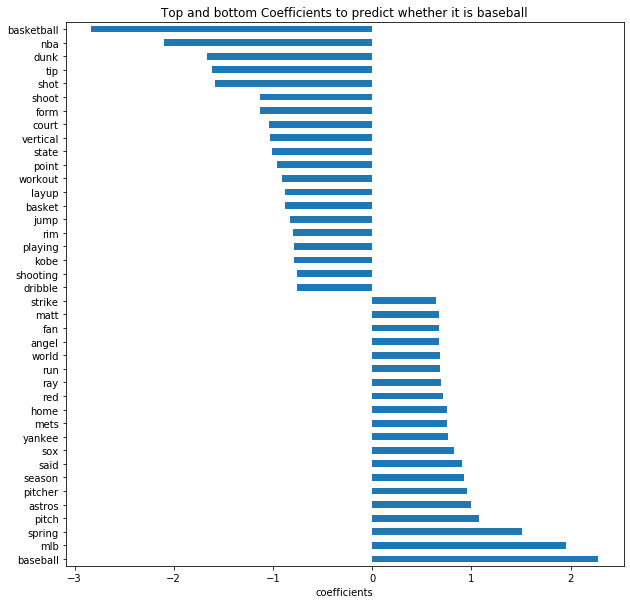

In [54]:
# Run best model with best parameters (CountVectorizer and LogisticRegression) 
cv_optim = CountVectorizer(stop_words = 'english', ngram_range=(1,1),max_df=1.0,min_df=1,max_features=4000)
X_train_cvec = cv_optim.fit_transform(X_train_clean[0]).todense()
X_test_cvec = cv_optim.transform(X_test_clean[0]).todense()

lr_optim = LogisticRegression(C=1)
lr_optim.fit(X_train_cvec, y_train)
y_train_pred=lr_optim.predict(X_train_cvec)
y_test_pred=lr_optim.predict(X_test_cvec)

# Top 20 words with high differentiating power
coef_names = cv_optim.get_feature_names()
coef_vals = lr_optim.coef_[0]
coef=pd.Series(coef_vals,index=coef_names).sort_values(ascending=False)

plt.figure(figsize=(10,10))
top_10=coef.head(20)
bottom_10=coef.tail(20)
pd.concat([top_10,bottom_10],axis=0).plot.barh(x=0,y=1)
plt.title('Top and bottom Coefficients to predict whether it is baseball');
plt.xlabel('coefficients');


Using gridsearch, Multinomial classifier with TFIDVectorizer was most effective in  classifying posts into Basketball and Baseball posts. This could help my company, SPORTS ILLUSTRATED, to effectively direct relevant basketball and baseball commentaries to respective editorial teams.

In addition, based on my Logistic Regression coefficients, a set of words with high differentiating power was obtained. There were differences in the words used in the basketball and baseball Reddit communities.
    
   -Basketball: More discussions/sharing on techniques to improve basketball. Commenters are usually basketball players, who are interested in improving their skills. For example, words 'dunk', 'shoot', 'jump', 'vertical', 'form', 'improve', 'rim' etc. For those who are more interested in basketball games tend to comment in subreddit 'nba'.
    
   -Baseball: Discussion focused on baseball teams and games (more like a baseball fan community). Commenters are mostly likely fans who follow baseball games closely. For example, 'Mets', 'Astros', 'SOX', 'Red', 'Yankee', 'Angels' etc. The equivalent for basketball is 'nba' in subreddit.


Recommendations

1) My selected subreddits - 'Basketball' and 'Baseball' were distinctively different so it was not much of a challenge to differentiate them. Most of the vectorizer and models obtained high scores. Perhaps it will be more interesting to explore subreddits like 'nba' and 'basketball' as they may be harder to differentiate, yet there are some subtle differences (suspect 'nba' to be a fan community, while 'basketball' is for basketball enthusiast). 

2) With our current results, magazines or advertisers may want to align their content to the interest of the commenters. For example, for basketball commenters maybe more interested in basketball related merchandise (e.g. balls, shoes, coaches, etc.) and information (e.g. techniques), while baseball commenters maybe more interested in baseball games related merchandise (e.g. merchanise of teams) and information (e.g. news on baseball teams and players).